In [1]:
import pandas as pd
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab  
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def intepmod1D(y):
    N=59
    dep=[]
    s=0.0
    for i in range(N):
        dep.append(s)
        if(i<20):
            s=s+0.2
        elif(i<40):
            s=s+1
        else:
            s=s+2.0 
    
    #print(len(x),len(y))
    cs = interp1d(dep, y,kind='cubic')
    xs = np.linspace(0,60,80)
    ys=cs(xs)
    return ys

def intepsw1D(y):
    x=np.linspace(4, 34, 16)
    #print(len(x),len(y))
    cs = interp1d(x, y,kind='cubic')
    xs = np.linspace(4,34,80)
    ys=cs(xs)
    #print(x)
    return ys
def inteprftn(y):
    x=np.linspace(0, 299, 299)
    #print(len(x),len(y))
    cs = interp1d(x, y,kind='cubic')
    xs = np.linspace(0,299,80)
    ys=cs(xs)
    #print(x)
    return ys
def get_tran_test_data(data):   
    X_sw=[]
    X_rf=[]
    y_train=[]
    k=0

    for index in data.index:
        #swdata=data.loc[index,'swdata']      
        #swdata=np.asfarray(swdata.split(','))
        rfdata=data.loc[index,'rftndata']      
        rfdata=np.asfarray(rfdata.split(','))
        #rftndata=rftn_reduce(rftndata)
        #swdata=intepsw1D(swdata)
        rfdata=inteprftn(rfdata)
        #mtmodel=data.loc[index,'modeldata']     
        #mtmodel=np.asfarray(mtmodel.split(','))
        #mtmodel=intepmod1D(mtmodel)
        #rftndata=rftn_reduce(rftndata)
        #X_train.append(np.hstack((rftndata,swdata)))

        #X_sw.append(swdata)
        X_rf.append(rfdata)
        #y_train.append(mtmodel)
     
    X_rf=np.array(X_rf)
    #X_sw=np.array(X_sw)
    #y_train=np.array(y_train)

    return X_rf



In [3]:
n_outputs1=80
smooth_marix=np.zeros((n_outputs1,n_outputs1))
for i in range(len(smooth_marix)-1):
    smooth_marix[i][i]=1
    smooth_marix[i][i+1]=-1
smooth_marix[-1][-2]=1
smooth_marix[-1][-1]=-1
smooth_marix=np.dot(np.transpose(smooth_marix), smooth_marix)

class neuralNetwork:
    def __init__(self):
        
        self.height =80
        self.width = 1
        self.channels = 2
        self.n_inputs = self.height * self.width
        self.n_outputs=80
        #self.drop=0.8
    def convolution_layer(self,X,conv1_fmaps,drop,lay_name):
        conv = tf.layers.conv2d(X, filters=conv1_fmaps, kernel_size=[4,1],
                         strides=1, padding="SAME",activation=tf.nn.elu, name=lay_name)
        
        conv_drop=tf.nn.dropout(conv,drop)
        return conv_drop
    
    def trans_convlution_layer(self,X,fmaps,lay_name):
        t_conv = tf.layers.conv2d_transpose(X,filters=fmaps, kernel_size=[3,1],
                                    strides=[2,1], padding="SAME",name=lay_name)
                                     
        return t_conv
        
    def forward(self):
        with tf.name_scope("inputs"):
            self.X = tf.placeholder(tf.float32, shape=[None, self.height, self.width, self.channels], name="X")
            self.y = tf.placeholder(tf.float32, shape=[None,self.n_outputs], name="y")
            self.alpha=tf.placeholder(tf.float32, shape=(), name="alpha")
            self.keep_prob= tf.placeholder(tf.float32, shape=(), name="regularizer")
           
        self.L12=self.convolution_layer(self.X,32,1,'layerL12')
        self.L13=self.convolution_layer(self.L12,32,1,'layerL13')
        
        self.L21 = tf.nn.max_pool(self.L13, ksize=[1, 2, 1, 1], strides=[1, 2, 1, 1],padding="SAME")
        self.L22=self.convolution_layer(self.L21,64,self.keep_prob,'layerL22')
        self.L23=self.convolution_layer(self.L22,64,self.keep_prob,'layerL23')
        
        self.L31 = tf.nn.max_pool(self.L23, ksize=[1, 2, 1, 1], strides=[1, 2, 1, 1],padding="SAME")
        self.L32=self.convolution_layer(self.L31,128,self.keep_prob,'layerL32')
        self.L33=self.convolution_layer(self.L32,128,self.keep_prob,'layerL33')
        
        self.L41 = tf.nn.max_pool(self.L33, ksize=[1, 2, 1, 1], strides=[1, 2, 1, 1],padding="SAME")
        self.L42=self.convolution_layer(self.L41,256,self.keep_prob,'layerL42')
        self.L43=self.convolution_layer(self.L42,256,self.keep_prob,'layerL43')
        
#         self.L51 = tf.nn.max_pool(self.L43, ksize=[1, 2, 1, 1], strides=[1, 2, 1, 1],padding="SAME")
#         self.L52=self.convolution_layer(self.L51,512,self.keep_prob,'layerL52')
#         self.L53=self.convolution_layer(self.L52,512,self.keep_prob,'layerL53')
        
#         self.R41=self.trans_convlution_layer(self.L53,256,'layerR41')
#         self.R41=tf.concat([self.L43, self.R41], 3)
#         self.R42=self.convolution_layer(self.R41,256,self.keep_prob,'layerR42')
#         self.R43=self.convolution_layer(self.R42,256,self.keep_prob,'layerR43')
        
        self.R31=self.trans_convlution_layer(self.L43,128,'layerR31')
        self.R31=tf.concat([self.L33, self.R31], 3)
        self.R32=self.convolution_layer(self.R31,128,1,'layerR32')
        self.R33=self.convolution_layer(self.R32,128,1,'layerR33')
        
        self.R21=self.trans_convlution_layer(self.R33,64,'layerR21')
        self.R21=tf.concat([self.L23, self.R21], 3)
        self.R22=self.convolution_layer(self.R21,64,1,'layerR22')
        self.R23=self.convolution_layer(self.R22,64,1,'layerR23')
        
        self.R11=self.trans_convlution_layer(self.R23,32,'layerR11')
        self.R11=tf.concat([self.L13, self.R11], 3)
        self.R12=self.convolution_layer(self.R11,64,1,'layerR12')
        self.R13=self.convolution_layer(self.R12,32,1,'layerR13')
        self.R14=self.convolution_layer(self.R13,16,1,'layerR14')
        self.R15=self.convolution_layer(self.R14,1,1,'layerR15')
        
        with tf.name_scope("train"):
            self.smooth_marix=tf.constant(np.transpose(smooth_marix),dtype=tf.float32)
            self.output=tf.reshape(self.R15, shape=[-1, self.height])
            self.sm=tf.reduce_mean(tf.square(tf.matmul(self.output, self.smooth_marix)),axis=1)
            self.loss1=tf.reduce_mean(tf.square(self.output - self.y),axis=1)
            self.loss = tf.reduce_mean(self.loss1+self.alpha*self.sm)
            optimizer = tf.train.AdamOptimizer()
            self.training_op = optimizer.minimize(self.loss)
        pass

In [4]:
def contact_tier(Xmt_resdata):
    height = 80
    width = 1
    channels = 1
    tier1=np.array(([(i+1)*0.1 for i in range(80)])*Xmt_resdata.shape[0])
    tier1=tier1.reshape(-1,height,width,channels)
    #Xsw_data=Xsw_data.reshape(-1,height,width,channels)
    Xmt_resdata=Xmt_resdata.reshape(-1,height,width,channels)
    #Xmt_phadata=Xmt_phadata.reshape(-1,height,width,channels)
    print(Xmt_resdata.shape)
    data1=np.concatenate((Xmt_resdata,tier1),axis=3)
    return data1

In [5]:
alldata=pd.read_csv('test_data_Li.dat',sep=',',header=0,index_col=0)
#alldata=pd.read_csv('K1.dat',sep=',',header=0,index_col=0)

In [6]:
alldata.head()

,rftndata
name,
51501,"0.000000,0.000000,0.000000,0.000000,-0.000000,..."
51503,"0.000000,0.000000,0.000000,-0.000000,-0.000000..."
51508,"0.000000,0.000000,0.000000,0.000000,0.000000,-..."
51536,"0.000000,0.000000,0.000000,0.000000,0.000000,-..."
51537,"0.000000,0.000000,0.000000,-0.000000,-0.000000..."


In [17]:
f=open('Pos_Li.txt','r')
Pos_Li=[]
index_Li=[]
for line in f:
    tem=[]
    temline=line.split()
    #print(temline)
    index_Li.append(int(temline[0]))
    tem.append(float(temline[1]))
    tem.append(float(temline[2]))
    Pos_Li.append(tem)
Pos_Li=np.array(Pos_Li)        
print(index_Li)

[51563, 51553, 51555, 51552, 51541, 51551, 51538, 51537, 51501, 51536, 51508, 51503, 62323, 62312, 62319, 62328, 62335, 62324, 62342, 62346, 62363, 62354, 62358, 62373, 62380, 62389, 62385, 62400, 62403, 61062, 61067, 61063, 61070, 61064]


In [18]:
alldata=alldata.loc[index_Li,:]

In [19]:
np.asfarray(alldata.loc[51501,'rftndata'].split(',')).shape

(299,)

In [20]:

X_test_rf=get_tran_test_data(alldata)
X_test=contact_tier(X_test_rf)

(34, 80, 1, 1)


In [21]:
X_test_rf.shape

(34, 80)

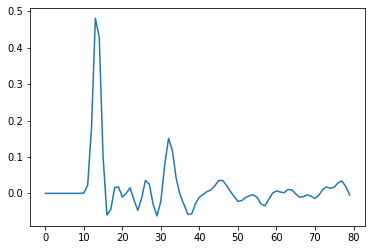

In [22]:
plt.plot(X_test_rf[0])
plt.show()

In [23]:
tf.reset_default_graph()
CNN_eq=neuralNetwork()
CNN_eq.forward()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()

In [24]:
with tf.Session() as sess:
    #saver.restore(sess,'CNNmodel/FCNinv8.27_enlarge.ckpt')
    saver.restore(sess,'Unetmodel/Unet_seis12.27.ckpt')
    logit_out = sess.run(CNN_eq.output,feed_dict={CNN_eq.X: X_test,CNN_eq.keep_prob:1})
    #logit_out=logit_out[:,59:118]

INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis12.27.ckpt


In [27]:
logit_out.shape

(34, 80)

In [140]:
x=Pos_Li[:,0]
deps = np.linspace(0,60,80)
val=[]
pos=[]
for i in range(len(x)):
    for j in range(len(deps)):
        tem=[]
        tem.append((x[i]-x[0])*11)
        tem.append(deps[j])
        
        pos.append(tem)
        val.append(logit_out[i][j])
        
pos=np.array(pos)
val=np.array(val)


In [141]:
pos

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.75949367],
       [ 0.        ,  1.51898734],
       ...,
       [77.77      , 58.48101266],
       [77.77      , 59.24050633],
       [77.77      , 60.        ]])

In [142]:
from scipy.interpolate import griddata
grid_x, grid_y = np.mgrid[0:78:600j, 0:60:300j]
grid_val = griddata(pos, val, (grid_x, grid_y), method='cubic')

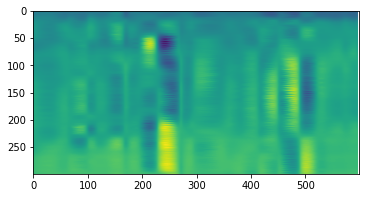

In [150]:
import pylab as pl  
import matplotlib as mpl 
fig = plt.figure(figsize=(6, 3))
plt.imshow(grid_val.T)
#fig,(ax0) = plt.subplots(1)
#c = ax0.pcolor(grid_val.T,edgecolors='k',linewidths=0.2,cmap=mpl.cm.rainbow)

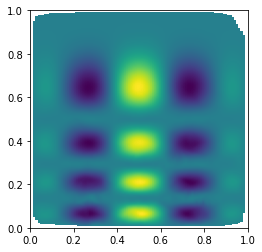

In [96]:
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]
rng = np.random.default_rng()
points = rng.random((1000, 2))
values = func(points[:,0], points[:,1])
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')
plt.imshow(grid_z2.T, extent=(0,1,0,1))

In [148]:
x

array([101.7 , 102.16, 102.43, 102.49, 102.87, 102.9 , 103.09, 103.3 ,
       103.66, 103.69, 103.79, 104.  , 104.39, 104.4 , 104.88, 104.9 ,
       104.95, 105.14, 105.2 , 105.79, 105.96, 106.21, 106.56, 106.63,
       107.01, 107.03, 107.48, 107.5 , 107.88, 108.09, 108.38, 108.47,
       108.7 , 108.77])

34 80


D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


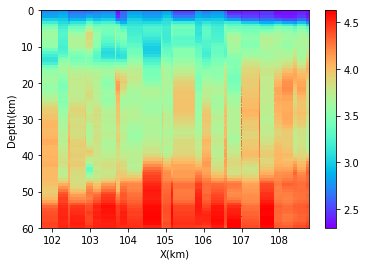

[51563 51553 51555 51552 51541 51551 51538 51537 51501 51536 51508 51503
 62323 62312 62319 62328 62335 62324 62342 62346 62363 62354 62358 62373
 62380 62389 62385 62400 62403 61062 61067 61063 61070 61064]
[ 0.          0.75949367  1.51898734  2.27848101  3.03797468  3.79746835
  4.55696203  5.3164557   6.07594937  6.83544304  7.59493671  8.35443038
  9.11392405  9.87341772 10.63291139 11.39240506 12.15189873 12.91139241
 13.67088608 14.43037975 15.18987342 15.94936709 16.70886076 17.46835443
 18.2278481  18.98734177 19.74683544 20.50632911 21.26582278 22.02531646
 22.78481013 23.5443038  24.30379747 25.06329114 25.82278481 26.58227848
 27.34177215 28.10126582 28.86075949 29.62025316 30.37974684 31.13924051
 31.89873418 32.65822785 33.41772152 34.17721519 34.93670886 35.69620253
 36.4556962  37.21518987 37.97468354 38.73417722 39.49367089 40.25316456
 41.01265823 41.7721519  42.53164557 43.29113924 44.05063291 44.81012658
 45.56962025 46.32911392 47.08860759 47.84810127 48.60759494 4

In [156]:
import pylab as pl  
import matplotlib as mpl 

def trans_surfer(x,z,val,fname):
    f=open(fname,'w')
    for i in range(len(x)):
        for j in range(len(z)):
            f.write('%f %f %f\n' %(x[i],-z[j],val[i][j]))
    f.close()

def data_transe(x,z,val,fname):
    f=open(fname,'w')
    for i in range(len(x)):
        f.write('%f ' %(x[i]))
    f.write('\n')
    for i in range(len(z)):
        f.write('%f ' %(-z[i]))
    for i in range(len(z)):
        f.write('\n')
        for j in range(len(x)):
            f.write('%f ' %(val[j][i]))
    print(len(x),len(z)) 
    f.close






def build_model(vel,dep,dir,file_str): 
    layerN=len(vel)  
    f=open(dir+file_str,'w')
    f.write('model96/'+file_str+'.model')
    f.write('\nTEST MODEL\nISOTROPIC\nKGS\nSPHERICAL EARTH\n1-D\nCONSTANT VELOCITY\nLINE08\nLINE09\nLINE10\nLINE11\n')
    f.write('H(KM)   VP(KM/S)   VS(KM/S) RHO(GM/CC)     QP         QS       ETAP       ETAS      FREFP      FREFS\n')
    H=[]
    Vs=[]
    Vp=[]
    Density=[]
    for i in range(layerN-1):
        vel1=round((vel[i]+vel[i+1])*0.5,4)
        H.append(dep[i+1]-dep[i])
        Vs.append(vel1)
        Vp.append(vel1*1.732)
        Density.append(0.77+0.32*vel1)
    H[-1]=0.0
    #print('!!!!!!!!!!!!!!')
    for i in range(layerN-1):
        f.write('\t%f\t%f\t%f\t%f\t0\t0\t0\t0\t1\t1\n' %(H[i],Vp[i],Vs[i],Density[i]))
    f.close()

def plotout(logit_out):
    #distance_file=open('K1_distance.dat','r')
    #distance_file=open('Distance_M2.dat','r')
    #distance_file=open('Distance.list','r')
    
    #distance_list=distance_file.readlines()
    #distance_file.close()

    vel=logit_out
    # vel1=vel
    # print(vel.shape)
    # for i in range(len(vel)):
    #     for j in range(len(vel[i])-1):
    #         vel1[i][j]=vel[i][j+1]-vel[i][j]
    #     vel1[i][-1]=vel1[i][-2]

    #x=np.asfarray(distance_list[0].split())
    #print(x)
    x=Pos_Li[:,0]
    N=59
    dep=[]
    s=0.0
    for i in range(N):
        dep.append(s)
        if(i<20):
            s=s+0.2
        elif(i<40):
            s=s+1
        else:
            s=s+2.0 
    deps = np.linspace(0,60,80)
    #print(x)
    #trans_surfer(x,dep,vel,'out-surf.dat')
    data_transe(x,deps,vel,'Li-mat.dat')
    x,z = np.meshgrid(x,deps)
    fig,(ax0) = plt.subplots(1)
    c = ax0.pcolor(x,z,logit_out.T,shading='flat',linewidths=0.2,cmap=mpl.cm.rainbow)
    fig.colorbar(c, ax=ax0)
    ax=fig.gca()
    ax.invert_yaxis()
    #plt.xlim(102,109)
    plt.xlabel('X(km)')
    plt.ylabel('Depth(km)')
    #c.set_clim(vmin=2, vmax=4.5)
    #fig.savefig('out1.png',dpi=(300.0))
    plt.show()

    #for i in range(len(logit_out)):
        #print(logit_out[i])
    #    build_model(logit_out[i],deps,'fit/fitmod/',alldata.index.values[i])   
    print(alldata.index.values)
    print(deps)

    

plotout(logit_out)

In [16]:
def add_noisy(X):
    N=len(X)
    nosi=(-1.0 + 2.0*np.random.random(N))*0.06
    X_add=X+nosi
    return X_add
def read_datapara(str_head):
    time=[]
    rtfn=[]
    f=open(str_head,'r')
    i=0.0
    t=-5
    dt=0.1
    for line in f:
        i=i+1
        if(i>30):
            for tem in line.split():
            #if(abs(float(tem))>1e-3):
                t=t+dt
                time.append(t)
                rtfn.append(float(tem))
    return time,rtfn

In [29]:
def output_asc(X,Xadd,fname):
    f=open(fname,'w')
    f.write("0.1000000     -0.1293207      0.3494176      -12345.00      -12345.00\n")
    f.write("-5.000000       97.30000       0.000000      -12345.00      -12345.00\n")
    f.write("-12345.00      -12345.00      -12345.00      -12345.00      -12345.00\n")
    f.write("-12345.00      -12345.00      -12345.00      -12345.00      -12345.00\n")    
    f.write("-12345.00      -12345.00      -12345.00      -12345.00      -12345.00\n") 
    f.write("-12345.00      -12345.00      -12345.00      -12345.00      -12345.00\n")
    f.write("-12345.00      -12345.00      -12345.00      -12345.00      -12345.00\n")
    f.write("-12345.00      -12345.00      -12345.00      -12345.00      -12345.00\n")
    f.write("2.500000      -12345.00      -12345.00      -12345.00      0.5000000E-01\n")
    f.write("100.0000      -12345.00      -12345.00      -12345.00      -12345.00\n")
    f.write("-12345.00      -12345.00      -12345.00      -12345.00      -12345.00\n")
    f.write("-12345.00      0.4751440E-02  -12345.00      -12345.00      -12345.00\n")
    f.write("-12345.00      -12345.00      -12345.00      -12345.00       0.000000\n")
    f.write("5.300000      -12345.00      -12345.00      -12345.00      -12345.00\n")
    f.write("  1970         1         0         0         0\n")
    f.write("     0         6         0         0      1024\n")
    f.write("-12345    -12345    -12345    -12345    -12345\n")
    f.write("     1    -12345         9    -12345    -12345\n")
    f.write("-12345    -12345    -12345    -12345    -12345\n")
    f.write("-12345    -12345    -12345    -12345    -12345\n")
    f.write("-12345    -12345    -12345    -12345    -12345\n")
    f.write("     1         1         1         1         0\n")
    f.write("RFTN    Rftn            \n")
    f.write("-12345  -12345  -12345  \n")
    f.write("-12345  -12345  -12345  \n")
    f.write("-12345  -12345  -12345  \n")
    f.write("-12345  -12345  -12345 \n")
    f.write("-12345  -12345  Rftn \n")
    f.write("hrftn96 -12345  Rftn\n")
    f.write("    -12345  -12345  \n")
    #tplt = "{0:^10}\t{1:^10}\t{2:^10}"
    for i in range(len(X)):
        if(i>=30 and i<249):
            #f.write("{:*^20}".format("hello world!"))
            f.write('%14e' %(Xadd[i-30]))
        else:
            f.write('%14e' %(X[i]))
        if((i+1)%5==0):
            f.write('\n')

219
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetm

(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt


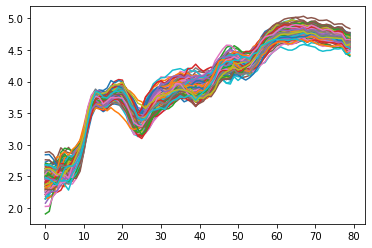

In [31]:
# coding=gbk
time,rftn=read_datapara('00.model.asc')
X=rftn[30:249]
#plt.plot(X)
print(len(X))
for i in range(100):
    X_add=add_noisy(X)
    output_asc(rftn,X_add,'case'+str(i)+'.asc')
    X_add=inteprftn(X_add)
    X_add=X_add.reshape(1,80,1,1)
    X_add=contact_tier(X_add)

    with tf.Session() as sess:
        #saver.restore(sess,'CNNmodel/FCNinv8.27_enlarge.ckpt')
        saver.restore(sess,'Unetmodel/Unet_seis11.9.ckpt')
        #logit_out0 = sess.run(CNN_eq.output,feed_dict={CNN_eq.X: X_test,CNN_eq.keep_prob:1})
        logit_out1 = sess.run(CNN_eq.output,feed_dict={CNN_eq.X: X_add,CNN_eq.keep_prob:1})
    #plt.plot(logit_out0[0])
    plt.plot(logit_out1[0])
plt.show()

(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt
(1, 80, 1, 1)
INFO:tensorflow:Restoring parameters from Unetmodel/Unet_seis11.9.ckpt


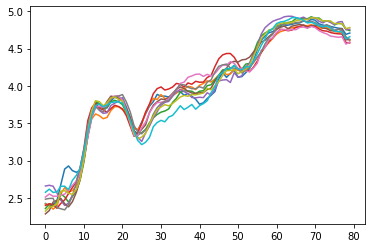

In [71]:

X=X_test_rf[0]

for i in range(10):
    X_add=add_noisy(X)
    #plt.plot(X)
    #plt.plot(X_add)
    #plt.show()
    
    X_add=X_add.reshape(1,80,1,1)
    X_add=contact_tier(X_add)

    with tf.Session() as sess:
        #saver.restore(sess,'CNNmodel/FCNinv8.27_enlarge.ckpt')
        saver.restore(sess,'Unetmodel/Unet_seis11.9.ckpt')
        #logit_out0 = sess.run(CNN_eq.output,feed_dict={CNN_eq.X: X_test,CNN_eq.keep_prob:1})
        logit_out1 = sess.run(CNN_eq.output,feed_dict={CNN_eq.X: X_add,CNN_eq.keep_prob:1})
    #plt.plot(logit_out0[0])
    plt.plot(logit_out1[0])
plt.show()

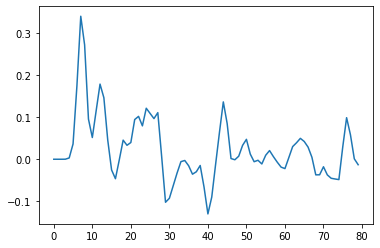

In [73]:
plt.plot(X)
#plt.plot(X_add)
plt.show()


(1, 80, 1, 1)